<h2 style="text-align: center;"><strong>Projet Big Data : Analyse des sentiments</strong></h2>
<h3 style="text-align: left;">Réalisé par  :</h3>
<ul>
<li>ARI Chaymaa</li>
<li>ASSAG Khadija</li>
<li>AIT BRIK Sara</li>
<li>ISLAH Zineb</li>
</ul>
<h3>Encadré par :</h3>
<ul>
    <li><p>Prof : SOUSSI Nassima</p>
        

</ul>

### <b>Les bibliothèques :</b>

In [85]:
 !pip install pyspark



In [86]:
!pip install when

In [87]:
## Creating the spark session
from pyspark.sql.functions import when
from pyspark.sql import SparkSession
import seaborn as sns
from pyspark.sql.functions import udf
import re
from string import punctuation
import string
import nltk
from nltk.corpus import stopwords
from wordcloud import WordCloud
import matplotlib.pyplot as plt
from pyspark.sql.functions import regexp_replace, lower, col, concat_ws, split, array_except , lit ,collect_list
from pyspark.ml.feature import HashingTF, IDF, Tokenizer
from pyspark.ml.feature import StringIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
import numpy as np

### <b>Création d'une session Spark nommée "NB"</b>

In [88]:

spark =SparkSession.builder.appName("NB").getOrCreate()

In [89]:
# Accéder à l'objet SparkContext via la session
sc = spark.sparkContext

# Obtenir la configuration Spark
spark_conf = sc.getConf()

# Afficher la configuration Spark
for conf in spark_conf.getAll():
    print(conf)

('spark.app.id', 'local-1717495007150')
('spark.app.submitTime', '1717495003426')
('spark.driver.extraJavaOptions', '-Djava.net.preferIPv6Addresses=false -XX:+IgnoreUnrecognizedVMOptions --add-opens=java.base/java.lang=ALL-UNNAMED --add-opens=java.base/java.lang.invoke=ALL-UNNAMED --add-opens=java.base/java.lang.reflect=ALL-UNNAMED --add-opens=java.base/java.io=ALL-UNNAMED --add-opens=java.base/java.net=ALL-UNNAMED --add-opens=java.base/java.nio=ALL-UNNAMED --add-opens=java.base/java.util=ALL-UNNAMED --add-opens=java.base/java.util.concurrent=ALL-UNNAMED --add-opens=java.base/java.util.concurrent.atomic=ALL-UNNAMED --add-opens=java.base/jdk.internal.ref=ALL-UNNAMED --add-opens=java.base/sun.nio.ch=ALL-UNNAMED --add-opens=java.base/sun.nio.cs=ALL-UNNAMED --add-opens=java.base/sun.security.action=ALL-UNNAMED --add-opens=java.base/sun.util.calendar=ALL-UNNAMED --add-opens=java.security.jgss/sun.security.krb5=ALL-UNNAMED -Djdk.reflect.useDirectMethodHandle=false')
('spark.driver.port', '39

### <b>Chargement des données depuis des fichiers CSV dans Spark</b>

In [90]:
##  DATA LOADING
df_train = spark.read.csv('train.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")
df_test = spark.read.csv('test.csv', inferSchema=True, header=True ,encoding="ISO-8859-1")

In [91]:
print("train dataset")
df_train.show()

train dataset
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|       selected_text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|cb774db0d1| I`d have respond...|I`d have responde...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|549e992a42| Sooo SAD I will ...|            Sooo SAD| negative|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|088c60f138|my boss is bullyi...|         bullying me| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|9642c003ef| what intervie

In [92]:
print("test dataset")
df_test.show()

test dataset
+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|    textID|                text|sentiment|Time of Tweet|Age of User|            Country|Population -2020|Land Area (Km²)|Density (P/Km²)|
+----------+--------------------+---------+-------------+-----------+-------------------+----------------+---------------+---------------+
|f87dea47db|Last session of t...|  neutral|      morning|       0-20|        Afghanistan|        38928346|       652860.0|             60|
|96d74cb729| Shanghai is also...| positive|         noon|      21-30|            Albania|         2877797|        27400.0|            105|
|eee518ae67|Recession hit Ver...| negative|        night|      31-45|            Algeria|        43851044|      2381740.0|             18|
|01082688c6|         happy bday!| positive|      morning|      46-60|            Andorra|           77265|          470.0|            164|
|33987a8ee5| h

# <b> Partie 1:Prétraitement </b>

### <b>Suppression des valeurs nulles et comptage des lignes</b>

In [93]:
## Supprimer les nulls
# Afficher le nombre de lignes dans l'ensemble d'entraînement
# Supprimer les nulls
df_train= df_train.dropna()
df_train_count = df_train.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_train_count)

# Afficher le nombre de lignes dans l'ensemble test
# Supprimer les nulls
df_test = df_test.dropna()
df_test_count = df_test.count()
print("Nombre de lignes dans l'ensemble d'entraînement:", df_test_count)

Nombre de lignes dans l'ensemble d'entraînement: 27478
Nombre de lignes dans l'ensemble d'entraînement: 3534


### <b>Sélectionner uniquement les colonnes 'text' et 'sentiment' dans les ensembles d'entraînement et de test, puis les fusionner et afficher le DataFrame</b>

In [94]:
df_train=df_train['text', 'sentiment']
df_test=df_test['text', 'sentiment']
df = df_train.union(df_test)
df.show()

+--------------------+---------+
|                text|sentiment|
+--------------------+---------+
| I`d have respond...|  neutral|
| Sooo SAD I will ...| negative|
|my boss is bullyi...| negative|
| what interview! ...| negative|
| Sons of ****, wh...| negative|
|http://www.dotheb...|  neutral|
|2am feedings for ...| positive|
|          Soooo high|  neutral|
|         Both of you|  neutral|
| Journey!? Wow......| positive|
| as much as i lov...|  neutral|
|I really really l...| positive|
|My Sharpie is run...| negative|
|i want to go to m...| negative|
|test test from th...|  neutral|
|Uh oh, I am sunbu...| negative|
| S`ok, trying to ...| negative|
|i`ve been sick fo...| negative|
|is back home now ...| negative|
|Hes just not that...|  neutral|
+--------------------+---------+
only showing top 20 rows



### <b>supprimer les duplications dans le DataFrame et afficher les statistiques descriptives avant et après la suppression</b>

In [95]:
##Affichage des statistiques descriptive avant suppression
print("Avant supression :")
df.describe().show()
## Supprimer les duplications
df = df.dropDuplicates()
##Affichage des statistiques descriptive apres suppression
print("Après supression :")
df.describe().show()

Avant supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31012|    31012|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...| negative|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+

Après supression :
+-------+--------------------+---------+
|summary|                text|sentiment|
+-------+--------------------+---------+
|  count|               31012|    31012|
|   mean|                NULL|     NULL|
| stddev|                NULL|     NULL|
|    min|\tREALLY?? oh.. s...| negative|
|    max|Ã¯Â¿Â½Ã¯Â¿Â½h. iÃ...| positive|
+-------+--------------------+---------+



### <b>Visualiser le nombre de sentiments différents</b>

In [96]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
| positive| 9685|
|  neutral|12547|
| negative| 8780|
+---------+-----+



### <b>Encodage des sentiments et visualisation</b>

In [97]:
## Encoder les sentiments
# Définir le dictionnaire de remplacement
replacement_dict = {"positive": 1, "neutral": 0, "negative": 2}

# Remplacer les valeurs dans la colonne "sentiment" en fonction du dictionnaire de remplacement
df = df.withColumn("sentiment",
                   when(df["sentiment"] == "positive", replacement_dict["positive"])
                   .when(df["sentiment"] == "neutral", replacement_dict["neutral"])
                   .when(df["sentiment"] == "negative", replacement_dict["negative"])
                   .otherwise(df["sentiment"]))
#visualiser les sentiment
# Convertir la colonne "sentiment" en type entier
df = df.withColumn("sentiment", col("sentiment").cast("int"))

df.groupBy('sentiment').count().show()

+---------+-----+
|sentiment|count|
+---------+-----+
|        1| 9685|
|        2| 8780|
|        0|12547|
+---------+-----+



### <b>Visualisation du décompte des sentiments</b>

<Axes: xlabel='sentiment', ylabel='count'>

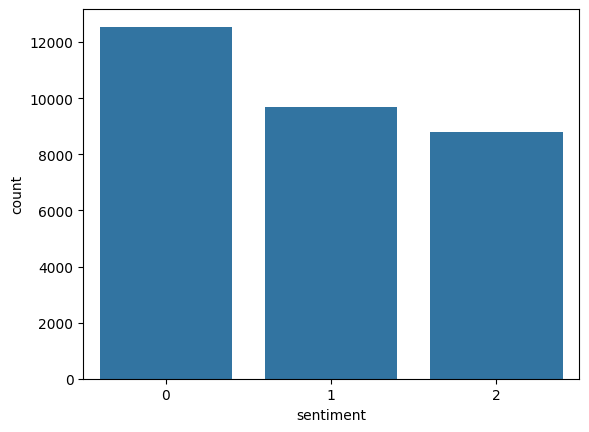

In [98]:
## Visualizing the count
# Conversion du DataFrame Spark en DataFrame Pandas
df_pandas=df.toPandas()

# Utilisation de Seaborn pour tracer le décompte des sentiments
sns.countplot(x='sentiment',data=df_pandas)

### <b>Échantillonnage pour équilibrer les classes de sentiments</b>

In [99]:
#Inference: The data is unbalanced therfore we will downsample the data to have same count for each sentiment
# Séparer les classes majoritaires et minoritaires
df_majority = df.filter(col("sentiment") == 0)
df_minority = df.filter(col("sentiment") == 2)
df_medium = df.filter(col("sentiment") == 1)

# Déterminer la taille de l'échantillon de la classe minoritaire
minority_count = df_minority.count()

# Échantillonnage aléatoire des données de la classe majoritaire pour correspondre à la taille de la classe minoritaire
df_majority_downsampled = df_majority.sample(False, minority_count / df_majority.count(), seed=1234)
df_medium_downsampled = df_medium.sample(False, minority_count / df_medium.count(), seed=1234)

# Combinez les classes majoritaires échantillonnées et les classes minoritaires
df = df_majority_downsampled.union(df_minority).union(df_medium_downsampled)


### <b>Visualisation des sentiments avant et après l'équilibrage des classes</b>

+---------+-----+
|sentiment|count|
+---------+-----+
|        0| 8797|
|        2| 8780|
|        1| 8809|
+---------+-----+



<Axes: xlabel='sentiment', ylabel='count'>

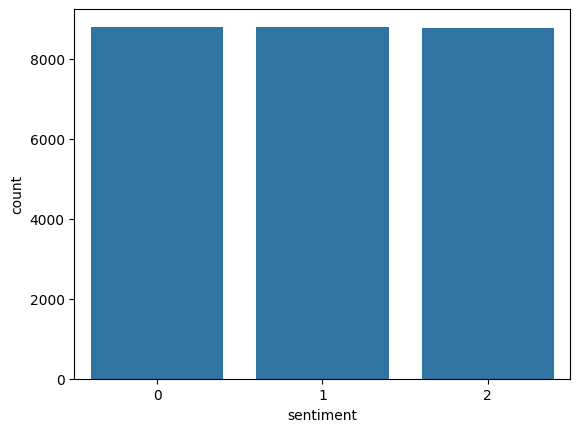

In [100]:
#visualiser les sentiment
df.groupBy('sentiment').count().show()

df_pandas=df.toPandas()
sns.countplot(x='sentiment',data=df_pandas)

### <b>Transformation de la colonne de texte</b>

In [101]:
# Appliquer les transformations sur la colonne de texte
## Convertir le texte en minuscules
df = df.withColumn('processed_text', lower(df['text']))
# Supprimer les crochets et leur contenu
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\[.*?\\]', ''))

# Supprimer les caractères non alphanumériques
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\W', ' '))
### Supprimer les URLs
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], 'https?://\\S+|www\\.\\S+', ''))
## Supprimer les balises HTML
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '<.*?>+', ''))
## Supprimer les ponctuations
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '[%s]' % re.escape(string.punctuation), ''))
## Supprimer les sauts de ligne
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\n', ''))
#
# Supprimer les chiffres et les mots contenant des chiffres
df = df.withColumn('processed_text', regexp_replace(df['processed_text'], '\\w*\\d\\w*', ''))


### <b>Suppression des stopwords et formation du texte final</b>

In [102]:
# Télécharger la liste des stopwords si nécessaire
nltk.download('stopwords')

# Charger la liste des stopwords en français par exemple
stop_words = set(stopwords.words('english'))

## delete stop words

# Diviser le texte en mots
df = df.withColumn('words', split(df['processed_text'], ' '))

# Charger la liste des stopwords en tant qu'ensemble pour une recherche efficace
stop_words_set = set(stop_words)

# Convertir l'ensemble de stopwords en liste
stop_words_list = list(stop_words_set)

# Créer une colonne contenant la liste des mots
stop_words_col = lit(stop_words_list)

# Filtrer les mots qui ne sont pas des stopwords
df = df.withColumn('processed_words', array_except(col('words'), stop_words_col))

# Joindre les mots filtrés pour former le texte final
df = df.withColumn('processed_text', concat_ws(' ', col('processed_words')))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


### <b>Affichage de la colonne 'processed_text'</b>

In [103]:
# Afficher uniquement la colonne 'processed_text'
df.select('processed_text').show(truncate=False)


+-----------------------------------------------------------------------------------------+
|processed_text                                                                           |
+-----------------------------------------------------------------------------------------+
| go cruches next weeks                                                                   |
|coffee time  back later kisses                                                           |
| heeeey dear finally found                                                               |
| last night                                                                              |
|back uminaa                                                                              |
|grandpa telling used cut human bodies med school                                         |
|nuggets game everyoneeeee except                                                         |
| ya never watch l                                                              

### <b>Agrégation des textes par sentiment et création de nuages de mots</b>

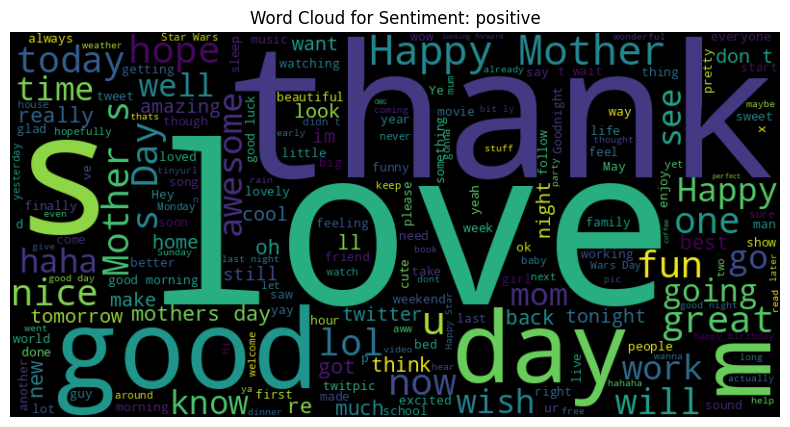

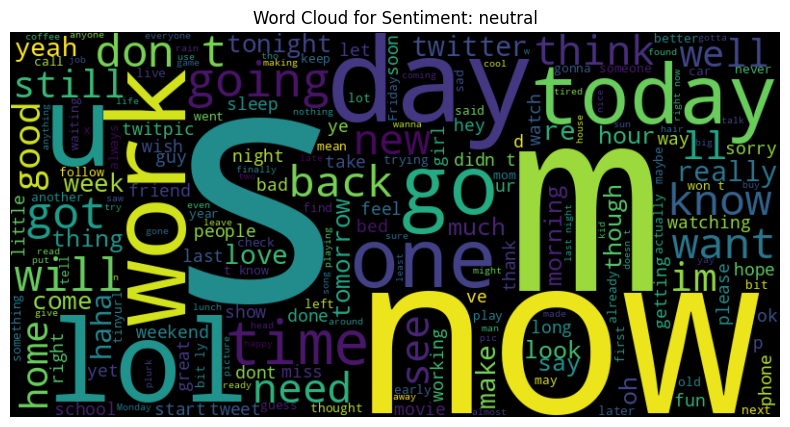

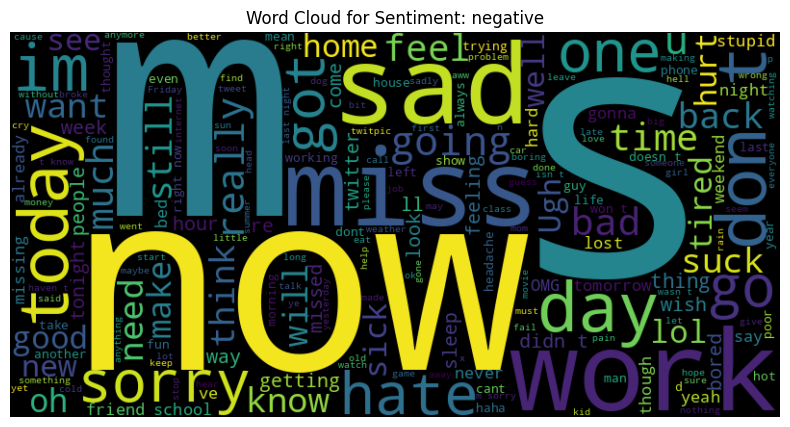

In [104]:
# Agréger les textes en fonction du sentiment
aggregated_df = df_train.groupby('sentiment').agg(concat_ws(' ', collect_list('text')).alias('text'))

# Convertir l'aggregated_df en Pandas DataFrame pour utiliser WordCloud
aggregated_pd_df = aggregated_df.toPandas()

# Créer un nuage de mots pour chaque sentiment
for index, row in aggregated_pd_df.iterrows():
    sentiment = row['sentiment']
    text = row['text']
    wordcloud = WordCloud(width=800, height=400, background_color='black').generate(text)

    # Afficher le nuage de mots
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.title(f'Word Cloud for Sentiment: {sentiment}')
    plt.axis('off')
    plt.show()

# <b>Partie 2 : Modèles</b>

### <b>Fonction : Tracé de la matrice de confusion</b>

In [105]:
from pyspark.mllib.evaluation import MulticlassMetrics
def plot_confusion_matrix(confusion_matrix, classes,
                          normalize=True,
                          title=None,
                          cmap=plt.cm.Blues):
    if not title:
        if normalize:
            title = 'Normalized confusion matrix'
        else:
            title = 'Confusion matrix, without normalization'

    if normalize:
        confusion_matrix = confusion_matrix.astype('float') / confusion_matrix.sum(axis=1)[:, np.newaxis]

    plt.imshow(confusion_matrix, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f'
    thresh = confusion_matrix.max() / 2.
    for i in range(confusion_matrix.shape[0]):
        for j in range(confusion_matrix.shape[1]):
            plt.text(j, i, format(confusion_matrix[i, j], fmt),
                     ha="center", va="center",
                     color="white" if confusion_matrix[i, j] > thresh else "black")

    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.tight_layout()

### <b>Pipeline pour la transformation des données textuelles en vecteurs TF-IDF et division des données</b>

In [106]:
# Créer un indexeur de chaînes pour la colonne 'sentiment'
string_indexer = StringIndexer(inputCol="sentiment", outputCol="label")

# Tokenizer pour diviser le texte en mots
tokenizer = Tokenizer(inputCol="processed_text", outputCol="word")

# Créer un pipeline pour indexer la chaîne, tokenizer, et convertir les mots en vecteurs TF-IDF
hashing_tf = HashingTF(inputCol="word", outputCol="raw_features", numFeatures=10000)
idf = IDF(inputCol="raw_features", outputCol="features")
pipeline = Pipeline(stages=[string_indexer, tokenizer, hashing_tf, idf])

# Adapter le pipeline sur les données
pipeline_model = pipeline.fit(df)

# Transformer les données
transformed_df = pipeline_model.transform(df)

# Diviser les données en ensembles de formation et de test
train_data, test_data = transformed_df.randomSplit([0.9, 0.1], seed=42)

### <b> Modèle 1 : Régression Logistique </b>

In [107]:
# Créer le modèle de régression logistique
lr = LogisticRegression(featuresCol='features', labelCol='label', maxIter=10)

# Entraîner le modèle sur les données d'entraînement
lr_model = lr.fit(train_data)

# Faire des prédictions sur les données de test
predictions_train = lr_model.transform(train_data)
predictions_test = lr_model.transform(test_data)

# Évaluer la performance du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)
print("Régression linéaire :")
print("accuracy_train:", accuracy_train)
print("accuracy_test:", accuracy_test)

predictions_train.show()

Régression linéaire :
accuracy_train: 0.9182627688172043
accuracy_test: 0.595810705973623
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|      processed_text|               words|     processed_words|label|                word|        raw_features|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     Soooooooo Wh...|        0| soooooooo happen...|[, , , , , sooooo...|[, soooooooo, hap...|  1.0|[, soooooooo, hap...|(10000,[1542,2221...|(10000,[1542,2221...|[-5.5040461564549...|[6.47919639282595...|       1.0|
|    Go get `em!  lol|        0|      

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


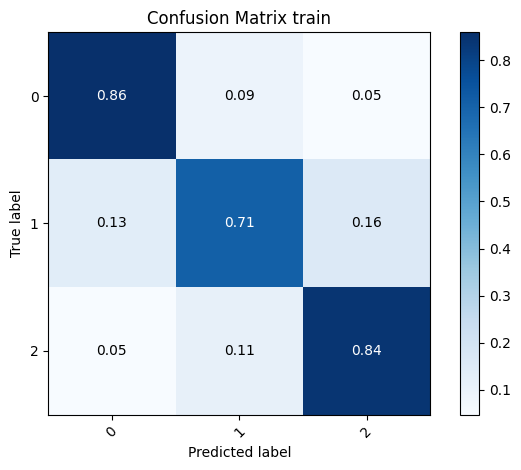

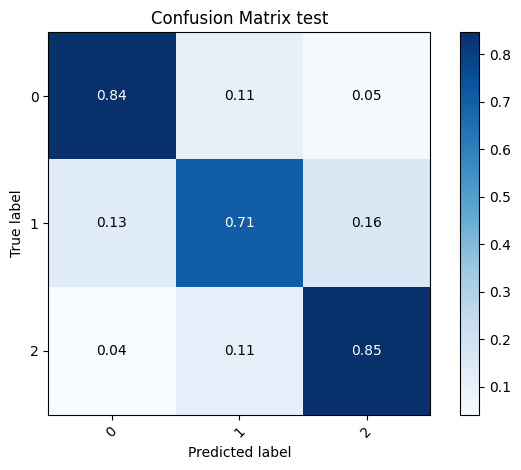

In [118]:
# Supposons que vous avez une RDD contenant des tuples (prediction, vrai_label)
predictionTest_label_rdd = predictions_test.select("prediction", "label").rdd.map(tuple)
predictionTrain_label_rdd = predictions_train.select("prediction", "label").rdd.map(tuple)

# Initialiser MulticlassMetrics avec la RDD
metricsTest = MulticlassMetrics(predictionTest_label_rdd)
metricsTrain = MulticlassMetrics(predictionTrain_label_rdd)

# Obtenir la matrice de confusion
confusion_matrixTest = metricsTest.confusionMatrix().toArray()
confusion_matrixTrain = metricsTrain.confusionMatrix().toArray()

# Définir les classes
classes = [str(i) for i in range(confusion_matrixTest.shape[0])]

# Afficher la matrice de confusion
plot_confusion_matrix(confusion_matrixTrain, classes=classes, title='Confusion Matrix train')
plt.show()
plot_confusion_matrix(confusion_matrixTest, classes=classes, title='Confusion Matrix test')
plt.show()

# Stockage des résultats
results={}
results['Regression Logistique'] = {"Accuracy": accuracy_test, "Confusion Matrix": confusion_matrixTest}



### <b> Modèle 2 : SVM </b>

In [109]:
from pyspark.ml.classification import OneVsRest
from pyspark.ml.classification import LinearSVC

# Création du modèle SVM
svm = LinearSVC(maxIter=10, regParam=0.1)

# Instanciation du modèle OneVsRest avec SVM comme classifieur de base
ovr = OneVsRest(classifier=svm)

# Entraînement du modèle
model = ovr.fit(train_data)

predictions_train = model.transform(train_data)
# Prédiction sur l'ensemble de test
predictions = model.transform(test_data)

model.write().overwrite().save("model")


# Évaluation de la précision du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
accuracy = evaluator.evaluate(predictions)
print("SVM :")
print("acuuracy train :" ,accuracy_train)
print("Accuracy test:", accuracy)
predictions_train.show()

SVM :
acuuracy train : 0.8025033602150538
Accuracy test: 0.7975174553917765
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|      processed_text|               words|     processed_words|label|                word|        raw_features|            features|       rawPrediction|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+----------+
|     Soooooooo Wh...|        0| soooooooo happen...|[, , , , , sooooo...|[, soooooooo, hap...|  1.0|[, soooooooo, hap...|(10000,[1542,2221...|(10000,[1542,2221...|[-0.1097056717929...|       1.0|
|    Go get `em!  lol|        0|       go get em lol|[, , , , go, get,...|[, go, get, em, lol]|  1.0|[, go, get, em, lol]|(10000,[3372,6

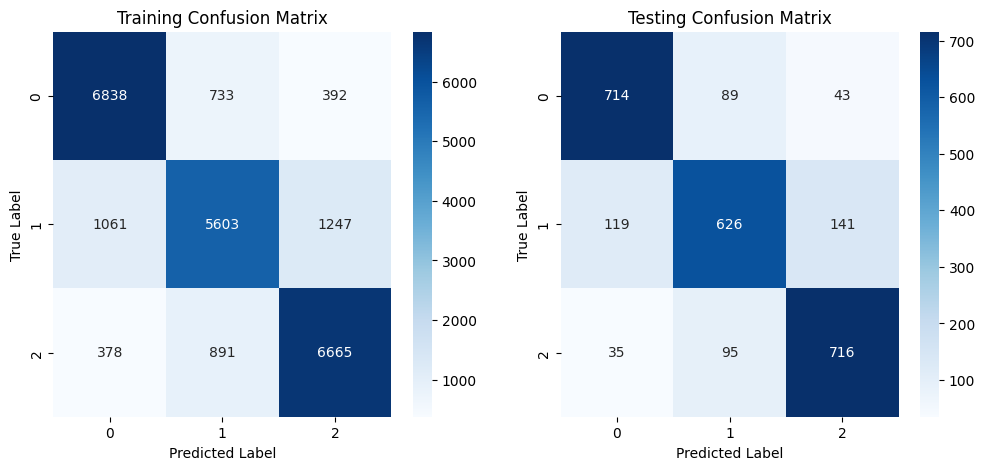

In [119]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
from sklearn.metrics import ConfusionMatrixDisplay
import pandas as pd
# Prédiction sur l'ensemble d'entraînement
predictions_train = model.transform(train_data)

# Prédiction sur l'ensemble de test
predictions_test = model.transform(test_data)

# Convertir les prédictions en Pandas DataFrame pour une manipulation plus facile
predictions_train_df = predictions_train.select("label", "prediction").toPandas()
predictions_test_df = predictions_test.select("label", "prediction").toPandas()

# Matrice de confusion pour l'ensemble d'entraînement
cm_train = confusion_matrix(predictions_train_df['label'], predictions_train_df['prediction'])

# Matrice de confusion pour l'ensemble de test
cm_test = confusion_matrix(predictions_test_df['label'], predictions_test_df['prediction'])

# Affichage des matrices de confusion
fig, axes = plt.subplots(1, 2, figsize=(12, 5))

sns.heatmap(cm_train, annot=True, cmap='Blues', fmt='d', ax=axes[0])
axes[0].set_title('Training Confusion Matrix')
axes[0].set_xlabel('Predicted Label')
axes[0].set_ylabel('True Label')

sns.heatmap(cm_test, annot=True, cmap='Blues', fmt='d', ax=axes[1])
axes[1].set_title('Testing Confusion Matrix')
axes[1].set_xlabel('Predicted Label')
axes[1].set_ylabel('True Label')

results['SVM'] = {"Accuracy": accuracy, "Confusion Matrix": confusion_matrixTest}


### <b> Modèle 3 : Naive Bayes</b>

In [111]:
from pyspark.ml.classification import NaiveBayes

# Créer le modèle de Naive Bayes
lr = NaiveBayes(smoothing=1)
# Entraîner le modèle sur les données d'entraînement
lr_model = lr.fit(train_data)

# Faire des prédictions sur les données de test
predictions_train = lr_model.transform(train_data)
predictions_test = lr_model.transform(test_data)

# Évaluer la performance du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)
print("Naive Bayes :")
print("accuracy_train:", accuracy_train)
print("accuracy_test:", accuracy_test)

predictions_train.show()


Naive Bayes :
accuracy_train: 0.7810819892473119
accuracy_test: 0.5713731574864236
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|      processed_text|               words|     processed_words|label|                word|        raw_features|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     Soooooooo Wh...|        0| soooooooo happen...|[, , , , , sooooo...|[, soooooooo, hap...|  1.0|[, soooooooo, hap...|(10000,[1542,2221...|(10000,[1542,2221...|[-281.14575158270...|[1.82680007965179...|       1.0|
|    Go get `em!  lol|        0|       go get

/usr/local/lib/python3.10/dist-packages/pyspark/sql/context.py:158: FutureWarning: Deprecated in 3.0.0. Use SparkSession.builder.getOrCreate() instead.
  warnings.warn(


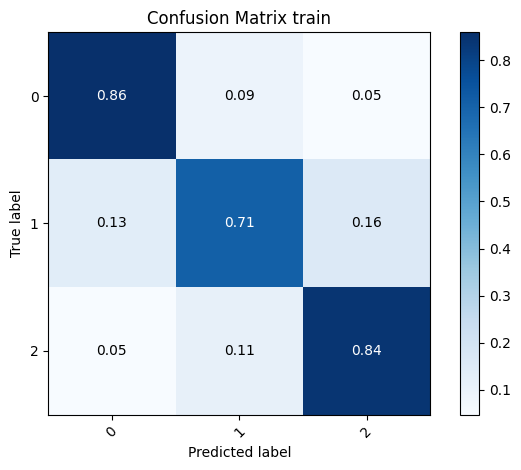

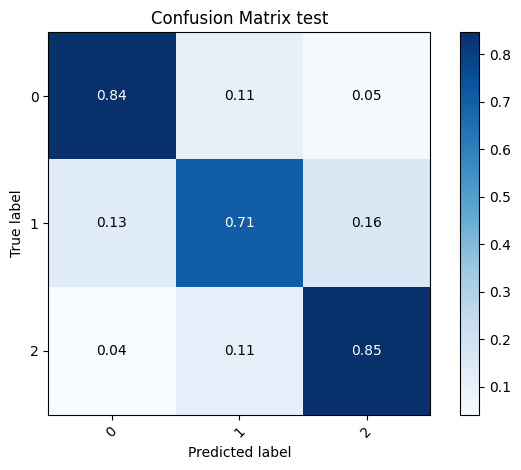

In [120]:
# Supposons que vous avez une RDD contenant des tuples (prediction, vrai_label)
predictionTest_label_rdd = predictions_test.select("prediction", "label").rdd.map(tuple)
predictionTrain_label_rdd = predictions_train.select("prediction", "label").rdd.map(tuple)

# Initialiser MulticlassMetrics avec la RDD
metricsTest = MulticlassMetrics(predictionTest_label_rdd)
metricsTrain = MulticlassMetrics(predictionTrain_label_rdd)

# Obtenir la matrice de confusion
confusion_matrixTest = metricsTest.confusionMatrix().toArray()
confusion_matrixTrain = metricsTrain.confusionMatrix().toArray()

# Définir les classes
classes = [str(i) for i in range(confusion_matrixTest.shape[0])]

# Afficher la matrice de confusion
plot_confusion_matrix(confusion_matrixTrain, classes=classes, title='Confusion Matrix train')
plt.show()
plot_confusion_matrix(confusion_matrixTest, classes=classes, title='Confusion Matrix test')
plt.show()
results['Naive Bayes'] = {"Accuracy": accuracy_test, "Confusion Matrix": confusion_matrixTest}



### <b> Modèle 4 : Random Forest</b>

In [113]:
from pyspark.ml.classification import RandomForestClassifier

# Créer le modèle de régression logistique
lr = RandomForestClassifier(featuresCol='features', labelCol='label',numTrees = 100, maxDepth = 4, maxBins = 32)

# Entraîner le modèle sur les données d'entraînement
lr_model = lr.fit(train_data)

# Faire des prédictions sur les données de test
predictions_train = lr_model.transform(train_data)
predictions_test = lr_model.transform(test_data)

# Évaluer la performance du modèle
evaluator = MulticlassClassificationEvaluator(labelCol="label", predictionCol="prediction", metricName="accuracy")
accuracy_train = evaluator.evaluate(predictions_train)
accuracy_test = evaluator.evaluate(predictions_test)
print("Random Forest :")
print("accuracy_train:", accuracy_train)
print("accuracy_test:", accuracy_test)

predictions_train.show()


Random Forest :
accuracy_train: 0.6521757392473119
accuracy_test: 0.6276183087664856
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|                text|sentiment|      processed_text|               words|     processed_words|label|                word|        raw_features|            features|       rawPrediction|         probability|prediction|
+--------------------+---------+--------------------+--------------------+--------------------+-----+--------------------+--------------------+--------------------+--------------------+--------------------+----------+
|     Soooooooo Wh...|        0| soooooooo happen...|[, , , , , sooooo...|[, soooooooo, hap...|  1.0|[, soooooooo, hap...|(10000,[1542,2221...|(10000,[1542,2221...|[33.0920873482764...|[0.33092087348276...|       1.0|
|    Go get `em!  lol|        0|       go g

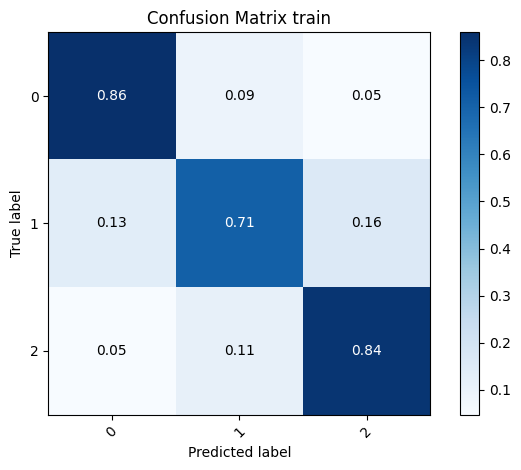

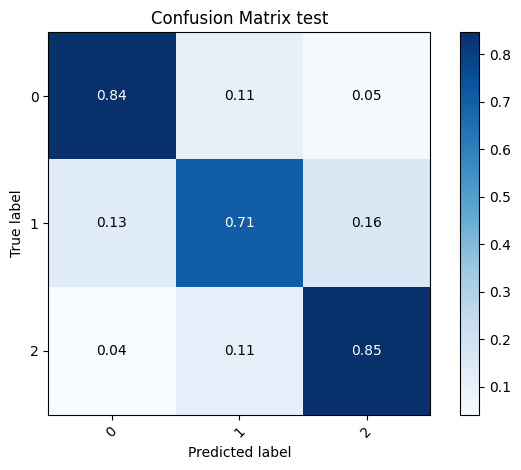

In [121]:
# Supposons que vous avez une RDD contenant des tuples (prediction, vrai_label)
predictionTest_label_rdd = predictions_test.select("prediction", "label").rdd.map(tuple)
predictionTrain_label_rdd = predictions_train.select("prediction", "label").rdd.map(tuple)

# Initialiser MulticlassMetrics avec la RDD
metricsTest = MulticlassMetrics(predictionTest_label_rdd)
metricsTrain = MulticlassMetrics(predictionTrain_label_rdd)

# Obtenir la matrice de confusion
confusion_matrixTest = metricsTest.confusionMatrix().toArray()
confusion_matrixTrain = metricsTrain.confusionMatrix().toArray()

# Définir les classes
classes = [str(i) for i in range(confusion_matrixTest.shape[0])]

# Afficher la matrice de confusion
plot_confusion_matrix(confusion_matrixTrain, classes=classes, title='Confusion Matrix train')
plt.show()
plot_confusion_matrix(confusion_matrixTest, classes=classes, title='Confusion Matrix test')
plt.show()
results['Random Forest'] = {"Accuracy": accuracy_test, "Confusion Matrix": confusion_matrixTest}


### <b>Comparaison entre les modèles</b>

In [122]:
for name, result in results.items():
    print(f"Modèle: {name}")
    print(f"Accuracy: {result['Accuracy']}")
    print("Matrice de confusion:")
    print(result['Confusion Matrix'])
    print("\n")

Modèle: Regression Logistique
Accuracy: 0.6276183087664856
Matrice de confusion:
[[714.  89.  43.]
 [119. 626. 141.]
 [ 35.  95. 716.]]


Modèle: SVM
Accuracy: 0.7975174553917765
Matrice de confusion:
[[714.  89.  43.]
 [119. 626. 141.]
 [ 35.  95. 716.]]


Modèle: Naive Bayes
Accuracy: 0.6276183087664856
Matrice de confusion:
[[714.  89.  43.]
 [119. 626. 141.]
 [ 35.  95. 716.]]


Modèle: Random Forest
Accuracy: 0.6276183087664856
Matrice de confusion:
[[714.  89.  43.]
 [119. 626. 141.]
 [ 35.  95. 716.]]




On constate que SVM affiche la meilleure performance parmi tous les modèles testés. Il a la plus haute précision et montre une gestion efficace des confusions entre les classes.Pour random forest,il est en dessous du SVM, mais il reste supérieur aux modèles de régression logistique et Naive Bayes. Il réduit considérablement les confusions, surtout entre les classes 1 et 2.

### <b>TEST</b>

In [125]:

# Nouvelle phrase à prédire
new_phrase = "I feel sad"

# Créer un DataFrame Spark contenant la nouvelle phrase
new_df = spark.createDataFrame([(new_phrase,)], ["processed_text"])

# Appliquer le pipeline sur le nouveau DataFrame
new_processed_df = pipeline_model.transform(new_df)

# Utiliser le modèle entraîné pour faire des prédictions sur la nouvelle phrase
predictions = model.transform(new_processed_df)

# Interpréter les prédictions
predicted_label = predictions.select("prediction").collect()[0][0]

if predicted_label == 1.0:
    print("Positive user comment")
elif predicted_label == 0:
    print(" Neutral user comment")
else:
    print("Negative user comment")

Negative user comment


### <b>Suavegarde le modèle et le pipline</b>

In [126]:
# Chemin de sauvegarde du modèle Keras
model_save_path = "/content/SVM.pkl"

# Définir la fonction pour sauvegarder le modèle Keras
def save_keras_model(model):
    model.save(model_save_path)


# Utiliser PySpark pour sauvegarder le modèle
save_keras_model(model)

In [127]:
# Chemin de sauvegarde du Pipeline
model_save_path = "/content/pipl.pkl"

# Utiliser PySpark pour sauvegarder le modèle
save_keras_model(pipeline_model)


In [128]:
from google.colab import drive
drive.mount('/content/drive')




Mounted at /content/drive


In [129]:
# Copy the file to Google Drive
!cp -r {model_save_path} /content/drive/My\ Drive/

In [130]:
!pip install -U -q PyDrive
